## Goal: simulate a 1D boundary layer of a magma ocean planet

# Current goals and issues

1. The spatial pattern for the uniform forcing $F_0$ case looks fine. √
2. The time evolution for the uniform forcing $F_0$ case looks fine. √
3. The spartial pattern for the diffential forcing $F(x)$ case is problematic. Something is wrong in the advection or the boundary conditions. 

In [120]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt 

In [168]:
# Create parameter class

class parameters:
    
    # Spatial grid
    rp   = 6314e3           # radius of the planet in m
    ndeg = 3                # number of X-grid
    ddeg = 1
    dx   = rp*np.pi/ndeg    # resolution of X-grid 
    x    = np.arange(0,ndeg+ddeg,ddeg)*dx        # X-grid in m
    xlen = len(x)           # length of X-grid
    
    # Temporal grid
    dt   = 180 # seconds
    tmin = 0
    tmax = dt*1e6
    t    = np.arange(tmin,tmax+dt,dt)
    tlen = len(t)
    
    # CFL criterion must be met
    if not dt/dx < 0.4:
        print('CFL criterion is not met.')
        quit()
        
    # Thermodynamics of Atmosphere
    M  = 18e-3    # molar weight of the atmosphere, unit in kg/mol
    R  = 8.314/M  # gas constant of the amtosphere, unit in J/kg/K          
    cp = 1864     # specific heat of the atmosphere, unit in J/kg/K
    cv = cp-R     # specific heat, unit in J/kg/K
    L  = 2260e3   # latent heat of condensation, unit in J/kg
    
    # Thermodynamics of Ocean
    cpo  = 1 # speficic of the liquid in ocean, unit in J/kg/K， water is 4184
    rhoo = 1000 # density of the ocean, unit in kg/m^3
    ho   = 75 # depth of the ocean, unit in m
    Co  = cpo*rhoo*ho # heat capacity of the ocean per unit surface area, J/m^2/K
    
    # Clausius-Clapeyron relation
    pref = 3533 # reference pressure in Pa
    Tref = 300  # reference temperature in K
    
    # Other parameters
    F = 800      # solar heating in W/m2 
    g   = 10     # gravity in m/s^2
    tau = dt*100 # friction damping timescale in s
    sigma = 5.67e-8

In [122]:
def get_esat(x):
    # Saturation Vapor Pressure
    # Input x could be T or Ts in K
    esat = np.zeros([par.xlen],dtype='float')
    esat = par.pref * np.exp(-(par.L/par.R)*(1/x - 1/par.Tref))
    return esat

In [123]:
def get_p0():
    # generate parameters (Fnet, p0) with specific distributions
    # example: [par.Fnet, par.p0] = get_para(option = 2)
    
#     p_free  = 0.1 * get_esat((par.F/5.67e-8)**0.25)    # pressure of free Atmosphere in Pa (~10% of the hottest surface pressure)
    
    p_free  = 0
    
    p0_array = np.ones([par.xlen],dtype='float')
    p0_array = p0_array * p_free
    
    return p0_array

In [124]:
def __init__(self):
    # generate variables and combine them with parameters
    self.Ts , self.ps   , self.rhodel, self.E       ,\
    self.u  ,\
    self.rho, self.delta, self.Cm    , self.Cu      ,\
    self.Fnet, self.OLR\
    = (np.zeros([parameters.tlen,parameters.xlen],dtype='float') for i in range(11))
        
#     self.Ts , self.ps   , self.rhodel, self.E       ,\
#     self.u  , self.e    , self.T     , self.p       ,\
#     self.rho, self.delta, self.Cm    , self.Cu      ,\
#     self.Ce,  self.Fnet, self.OLR,  self.P \
#     = (np.zeros([parameters.tlen,parameters.xlen],dtype='float') for i in range(16))

In [125]:
def get_Cm():
    # Diagnostic at current time step, i
    Cm = np.zeros([par.xlen],dtype='float')
    Cm = par.E[i,:]
    return Cm

In [126]:
def get_Cu():
    # Diagnostic at current time step, i
    Cu = np.zeros([par.xlen],dtype='float')
    
    for j in range(par.xlen):
        if par.E[i,j]>=0:
            Cu[j] = -par.rho[i,j]*par.delta[i,j]*par.u[i,j]/par.tau
            
        else:
            Cu[j] = -par.rho[i,j]  *par.delta[i,j]*par.u[i,j]/par.tau
            
    return Cu  

In [127]:
# def get_Ce():
#     # Diagnostic at current time step, i
#     Ce = np.zeros([par.xlen],dtype='float')
    
#     for j in range(par.xlen):
#         if par.E[i,j]>=0:
#             Ce[j] = (par.E[i,j]-par.P[i,j]) * (par.L) - par.Fnet[i,j]
#         else:
#             Ce[j] = (par.E[i,j]-par.P[i,j]) * (par.L) - par.Fnet[i,j]    
#     return Ce  

In [158]:
def get_Fnet(option = 1):
    # generate parameter (Fnet) with specific distributions
     
    # distribution of solar forcing
    if option == 1:     # uniform distribution
        F_solar = par.F * np.ones([par.xlen],dtype='float')
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
        
    elif option == 2:   # sine distribution (needs to be revised if periodic boundary condition)
        F_solar = par.F * (np.sin(np.pi/2 * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg) + 1)
        Fnet = F_solar - par.sigma * par.Ts[i+1,:] ** 4
    else:               # no forcing
        Fnet = np.zeros([par.xlen],dtype='float')

    return Fnet

In [129]:
def get_Ts(): 
    # Prognostic
    Ts = np.zeros([par.xlen],dtype='float')

    Ts = par.Ts[i,:] + par.dt / par.Co*\
            (
             par.Fnet[i,:] - par.L * par.E[i,:]
            )   
    return Ts

In [130]:
def get_ps(): 
    # Diagnostic
    ps = np.zeros([par.xlen], dtype='float')
    
    ps = get_esat(par.Ts[i+1, :])
    return ps

In [131]:
def get_rhodel(): 
    # Diagnostic
    rhodel = np.zeros([par.xlen],dtype='float')
    
    # interior (here -1 is required!!)
    rhodel[1:-1] = (par.ps[i+1, 1:-1] - par.p0[1:-1]) / par.g
    
    # left boundary
    rhodel[0] = rhodel[1]
    # right boundary
    rhodel[-1] = rhodel[-2]
    
    if (any(n < 0 for n in rhodel) == True):
        print("Minimum surface pressure Ps is {} Pa ".format(min(par.ps[i+1,:])))
        print('P_{free} too high! Quit.')
        quit()
    
    return rhodel

In [148]:
def get_u(): 
    # Prognostic
    rhodelu = np.zeros([par.xlen],dtype='float') # (t+1)
    u = np.zeros([par.xlen],dtype='float')       # (t+1)
    
    # interior
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
                         par.dt*(par.Cu[i,j] -                                                   
                                    (                                                                
                                    par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2   + par.ps[i,j])-   
                                    par.delta[i,j-1]*(par.rho[i,j-1]*par.u[i,j-1]**2 + par.ps[i,j-1]) 
                                    )/                                                               
                                    (par.x[j]-par.x[j-1])                                            
                                    )
        elif par.u[i,j]<0:
            rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
                         par.dt*(par.Cu[i,j] -                                                   
                                (                                                                
                                par.delta[i,j+1]*(par.rho[i,j+1]*par.u[i,j+1]**2   + par.ps[i,j+1])-   
                                par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2     + par.ps[i,j]) 
                                )/                                                               
                                (par.x[j+1]-par.x[j])                                            
                                )
#     for j in range(1, par.xlen-1):
#         if par.u[i,j]>=0:
#             rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
#                          par.dt*(par.Cu[i,j] -                                                   
#                                     (                                                                
#                                     par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2   + par.p[i,j])-   
#                                     par.delta[i,j-1]*(par.rho[i,j-1]*par.u[i,j-1]**2 + par.p[i,j-1]) 
#                                     )/                                                               
#                                     (par.x[j]-par.x[j-1])                                            
#                                     )
#         elif par.u[i,j]<0:
#             rhodelu[j] = par.rho[i,j]*par.delta[i,j]*par.u[i,j] +                                \
#                          par.dt*(par.Cu[i,j] -                                                   
#                                 (                                                                
#                                 par.delta[i,j+1]*(par.rho[i,j+1]*par.u[i,j+1]**2   + par.p[i,j+1])-   
#                                 par.delta[i,j]  *(par.rho[i,j]  *par.u[i,j]**2     + par.p[i,j]) 
#                                 )/                                                               
#                                 (par.x[j+1]-par.x[j])                                            
#                                 )
    # left and right boundaries are zero by construction
    u = rhodelu[:]/par.rhodel[i+1,:]
    
    return u

In [149]:
# def get_e(): # **
#     # Prognostic
#     rhodele = np.zeros([par.xlen],dtype='float') # (t+1)
#     e = np.zeros([par.xlen],dtype='float')       # (t+1)
#     # interior
#     for j in range(1, par.xlen-1):           # here xlen-1 is requied!
#         # insert criterion for direction of mean wind
#         if par.u[i,j]>=0:
#             rhodele[j] = par.rho[i,j]*par.delta[i,j]*par.e[i,j] +                                                  \
#                          par.dt*(par.Ce[i,j] -                                                                     
#                                     (                                                                             
#                                     par.delta[i,j]  *par.u[i,j]  *(par.rho[i,j]  *par.e[i,j]   + par.p[i,j])-     
#                                     par.delta[i,j-1]*par.u[i,j-1]*(par.rho[i,j-1]*par.e[i,j-1] + par.p[i,j-1])    
#                                     )/                                                                            
#                                     (par.x[j]-par.x[j-1])                                                         
#                                 )
# #             print("new rho delta e is {} ".format(rhodele[j]))
# #             print("old rho delta e is {}" .format(par.rhodel[i,j]*par.e[i,j]))
#         elif par.u[i,j]<0:
#             rhodele[j] = par.rho[i,j]*par.delta[i,j]*par.e[i,j] +                                                  \
#                          par.dt*(par.Ce[i,j] -                                                                     
#                                     (                                                                             
#                                     par.delta[i,j+1]*par.u[i,j+1]*(par.rho[i,j+1]*par.e[i,j+1] + par.p[i,j+1])-     
#                                     par.delta[i,j]  *par.u[i,j]  *(par.rho[i,j]  *par.e[i,j]   + par.p[i,j])    
#                                     )/                                                                            
#                                     (par.x[j+1]-par.x[j])                                                         
#                                 )
#     # left boundary
#     rhodele[0] = par.rho[i, 0]*par.delta[i,0]*par.e[i,0] + par.dt * par.Ce[i,0]
# #     print("new  rho delta e at bc is {} ".format(rhodele[0]))
# #     print("old  rho delta e at bc is {}" .format(par.rhodel[i,0]*par.e[i,0]))
    
#     # right boundary
#     rhodele[-1] = par.rho[i, -1]*par.delta[i,-1]*par.e[i,-1] + par.dt * par.Ce[i,-1]
#     e = rhodele[:]/par.rhodel[i+1,:]
    
#     return e

In [150]:
# def get_T():
#     # Diagnostic
#     T = np.zeros([par.xlen], dtype='float') # (t+1)
#     # interior      # here -1 is requied!
#     T[1: -1] = (1/par.cv) * (par.e[i+1,1:-1] - 0.5*par.u[i+1, 1:-1]**2)
#     # left boundary (no flux)
#     T[0] = T[1]
#     # right boundary (no flux)
#     T[-1] = T[-2]
#     return T

In [151]:
# def get_p():
#     # Diagnostic
#     p = np.zeros([par.xlen],dtype='float') # (t+1)
#     p = get_esat(par.T[i+1,:])
#     return p

In [152]:
def get_rho():
    # Diagnostic
    rho = np.zeros([par.xlen],dtype='float') # (t+1)
#     rho = par.p[i+1,:]/(par.R * par.T[i+1,:])
    rho = par.ps[i+1,:]/(par.R * par.Ts[i+1,:])
    return rho

In [153]:
def get_delta():
    # Diagnostic
    delta = np.zeros([par.xlen],dtype='float') # (t+1)
    delta = par.rhodel[i+1,:]/par.rho[i+1,:]
    return delta

In [154]:
def get_E(): # **
    # Diagnostic
    E = np.zeros([par.xlen],dtype='float') # (t+1)
      
    term1 = (par.ps[i+1,:] * par.L**2) / (par.R*par.Ts[i+1,:]**2*par.Co)
#     print(term1)
    
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            E[j] =  (par.Fnet[i+1,j] * (par.ps[i+1,j]*par.L) / (par.R*par.Ts[i+1,j]**2*par.Co)  
                        + par.g*(                                                                 
                                par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]              
                               -par.rho[i+1,j-1]*par.delta[i+1,j-1]*par.u[i+1,j-1]        
                                )/(par.x[j]-par.x[j-1])
                        )/(par.g + (par.ps[i+1,j]*par.L**2)/(par.R*par.Ts[i+1,j]**2*par.Co))
        elif par.u[i,j]<0:
            E[j] = (par.Fnet[i+1,j]*(par.ps[i+1,j]*par.L)/(par.R*par.Ts[i+1,j]**2*par.Co)  
                        + par.g*(                                                                 
                                par.rho[i+1,j+1]*par.delta[i+1,j+1]*par.u[i+1,j+1]           
                               -par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]        
                                )/(par.x[j+1]-par.x[j])
                        )/(par.g +(par.ps[i+1,j]*par.L**2)/(par.R*par.Ts[i+1,j]**2*par.Co))   
            
    # left boundary
    j = 0
    E[j] =  (par.Fnet[i+1,j]*(par.ps[i+1,j]*par.L)/(par.R*par.Ts[i+1,j]**2*par.Co)  
               +par.g*(                                                                 
                        par.rho[i+1,j+1]*par.delta[i+1,j+1]*par.u[i+1,j+1]           
                        -par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]        
                    )/(par.x[j+1]-par.x[j])
                )/(par.g + (par.ps[i+1,j]*par.L**2)/(par.R*par.Ts[i+1,j]**2*par.Co))
   
    # right boundary
    j = par.xlen-1
    E[j] =  (par.Fnet[i+1,j]*(par.ps[i+1,j]*par.L)/(par.R*par.Ts[i+1,j]**2*par.Co)  
                +par.g*(                                                                 
                        par.rho[i+1,j]  *par.delta[i+1,j]  *par.u[i+1,j]              
                        -par.rho[i+1,j-1]*par.delta[i+1,j-1]*par.u[i+1,j-1]        
                        )/(par.x[j]-par.x[j-1])
                )/(par.g + (par.ps[i+1,j]*par.L**2)/(par.R*par.Ts[i+1,j]**2*par.Co))

    return E

In [165]:
def get_initial_conditions(Ts0 = 400, u0 = 0, option = 1):
    # Scenario: intially saturated atmosphere with uniform Ts,T,p,delta,etc.
    i = 0
    
    par.Ts[i,:]       = np.ones([par.xlen],dtype='float') * Ts0  # uniform initial temp
    par.ps[i,:]       = get_esat(par.Ts[i,:])  # uniform initial pressure
    par.rhodel[i,:]   = (par.ps[0,:]-par.p0[:])/par.g           # uniform atmospheric mass
    par.u[i,:]        = np.ones([par.xlen],dtype='float') * u0  # initial wind
    par.u[i,0:1]   = 0 
    par.u[i,-2:-1] = 0 
#     par.T[i,:]        = par.Ts[0,:]                             # T = Ts
#     par.e[i,:]        = par.cv*par.T[0,:] + 0.5*par.u[0,:]**2 
#     par.p[i,:]        = par.ps[0,:]                             # p = ps
#     par.rho[i,:]      = par.p[0,:]/(par.R*par.T[0,:])
    par.rho[i,:]      = par.ps[0,:]/(par.R*par.Ts[0,:])
    par.delta[i,:]    = par.rhodel[0,:]/par.rho[0,:]          
    
    # distribution of initial solar forcing
    par.Fnet[i,:] = np.zeros([par.xlen],dtype='float')
    if option == 1:     # uniform distribution
        F_solar = par.F * np.ones([par.xlen],dtype='float')
        par.Fnet[i,:] = F_solar - par.sigma * par.Ts[i,:] **4      
    elif option == 2:   # cosine distribution (needs to be revised if periodic boundary condition)
        F_solar = par.F * np.cos(np.pi * np.arange(0, par.ndeg + par.ddeg, par.ddeg) / par.ndeg)
        par.Fnet[i,:] = F_solar - par.sigma * par.Ts[i,:] **4
    
        
    par.E[i,:]    = np.zeros([par.xlen],dtype='float')      # zero surface mass-flux         
    for j in range(1, par.xlen-1):
        if par.u[i,j]>=0:
            par.E[i, j] =  (par.Fnet[i,j] * (par.ps[i,j]*par.L) / (par.R*par.Ts[i,j]**2*par.Co)  
                        + par.g*(                                                                 
                                par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]              
                               -par.rho[i,j-1]*par.delta[i,j-1]*par.u[i,j-1]        
                                )/(par.x[j]-par.x[j-1])
                        )/(par.g + (par.ps[i,j]*par.L**2)/(par.R*par.Ts[i,j]**2*par.Co))
        elif par.u[i,j]<0:
            par.E[i,j] = (par.Fnet[i,j]*(par.ps[i,j]*par.L)/(par.R*par.Ts[i,j]**2*par.Co)  
                        + par.g*(                                                                 
                                par.rho[i,j+1]*par.delta[i,j+1]*par.u[i,j+1]           
                               -par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]        
                                )/(par.x[j+1]-par.x[j])
                        )/(par.g +(par.ps[i,j]*par.L**2)/(par.R*par.Ts[i,j]**2*par.Co))   
    # left boundary
    j = 0
    par.E[i,j] =  (par.Fnet[i,j]*(par.ps[i,j]*par.L)/(par.R*par.Ts[i,j]**2*par.Co)  
               +par.g*(                                                                 
                        par.rho[i,j+1]*par.delta[i,j+1]*par.u[i,j+1]           
                        -par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]        
                    )/(par.x[j+1]-par.x[j])
                )/(par.g + (par.ps[i,j]*par.L**2)/(par.R*par.Ts[i,j]**2*par.Co))
    # right boundary
    j = par.xlen-1
    par.E[i,j] =  (par.Fnet[i,j]*(par.ps[i,j]*par.L)/(par.R*par.Ts[i,j]**2*par.Co)  
                +par.g*(                                                                 
                        par.rho[i,j]  *par.delta[i,j]  *par.u[i,j]              
                        -par.rho[i,j-1]*par.delta[i,j-1]*par.u[i,j-1]        
                        )/(par.x[j]-par.x[j-1])
                )/(par.g + (par.ps[i,j]*par.L**2)/(par.R*par.Ts[i,j]**2*par.Co))
    
#     par.P[i,:]    = np.zeros([par.xlen],dtype='float')
#     par.P[i,:] = par.E[i,:] - (par.Fnet[i,:] - par.OLR[i,:]) / par.L

    #print(par.rhodel[0,:])
    #print(par.e[0,:])
    #print(par.p[0,:])
    #print(par.rho[0,:])
    #print(par.delta[0,:])

In [169]:
# Time Integration
par = parameters()
__init__(par)
par.p0 = get_p0()
get_initial_conditions()

for i in range(par.tlen-1): 
    # Get variables at current time step
    par.Cm[i,:]         = get_Cm()
    par.Cu[i,:]         = get_Cu()
#     par.Ce[i,:]         = get_Ce()

    # Get variables at the next time step
    par.Ts[i+1,:]       = get_Ts()
    par.Fnet[i+1,:]     = get_Fnet(option=1)
    par.ps[i+1,:]       = get_ps()
    par.rho[i+1,:]      = get_rho()
    par.rhodel[i+1,:]   = get_rhodel()
    par.delta[i+1,:]    = get_delta() 
    par.u[i+1,:]        = get_u()        
#     par.e[i+1,:]        = get_e()   
#     par.T[i+1,:]        = get_T()
#     par.p[i+1,:]        = get_p()        
#     par.rho[i+1,:]      = get_rho()  
#     par.delta[i+1,:]    = get_delta()   
    par.E[i+1,:]      = get_E() 
    
#     par.P[i+1,:] = par.E[i+1,:] - (par.Fnet[i+1,:] - par.OLR[i+1,:]) / par.L
    
    f_report = 10        # report every time when this fraction is completed
    idx = (par.tlen-1)/f_report
    if (i%idx == 0 ):
        progress = round(i/par.tlen*100)
        print("{} % completed".format(progress))
        
print('Success!')

0 % completed
10 % completed
20 % completed
30 % completed
40 % completed
50 % completed
60 % completed
70 % completed
80 % completed
90 % completed
Success!


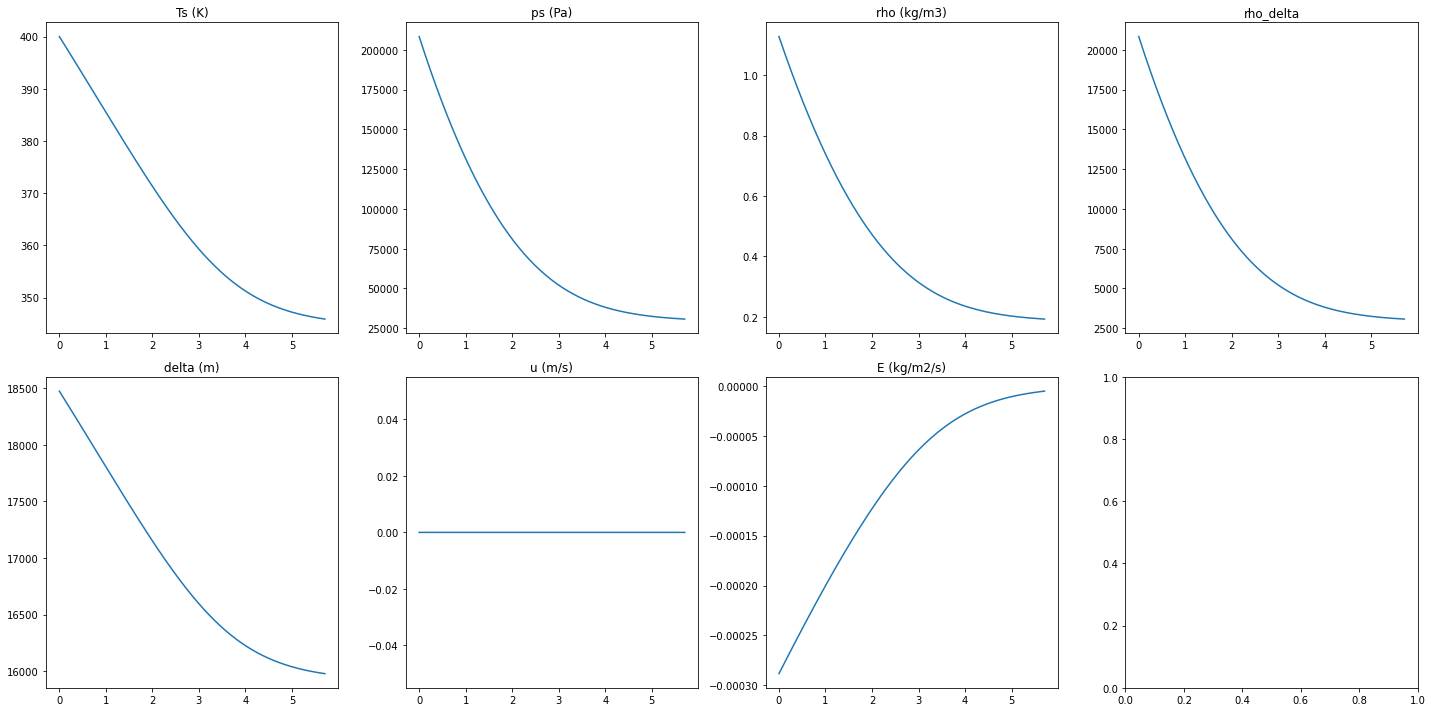

In [170]:
# Plot time-evolution  
fig, ax = plt.subplots(2,4,figsize=(20,10)) 

L_year = 3600*24*365

# Plot at end of the simulation
ax[0,0].plot(par.t/L_year,par.Ts[:,0]) 
ax[0,1].plot(par.t/L_year,par.ps[:,0]) 
ax[0,2].plot(par.t/L_year,par.rho[:,0]) 
ax[0,3].plot(par.t/L_year,par.rhodel[:,0]) 
ax[1,0].plot(par.t/L_year,par.delta[:,0])
ax[1,1].plot(par.t/L_year,par.u[:,0]) 
ax[1,2].plot(par.t/L_year,par.E[:,0])

ax[0,0].set_title('Ts (K)')
ax[0,1].set_title('ps (Pa)')
ax[0,2].set_title('rho (kg/m3)')
ax[0,3].set_title('rho_delta')
ax[1,0].set_title('delta (m)')
ax[1,1].set_title('u (m/s)')
ax[1,2].set_title('E (kg/m2/s)')

# for i in (0,1):
#     for j in (0,4):
#         ax[i,j].set_xlim([0.3, 0.6])

plt.tight_layout()
plt.show()

In [ ]:
# print(par.Ts[:,0])
# print(par.ps[:,0])
# print(par.rhodel[:,0])
# print(par.e[:,0])
# print(par.T[:,0])
# print(par.p[:,0])
# print(par.rho[:,0])
# print(par.delta[:,0])
print(par.E[:,0])
print(par.P[:,0])

1. Warm start (compared to EQ, T > Ts, p > ps, check "e")
2. Switch from non - periodic to periodic domain
3. Merge the codes with the latest version!
4. 

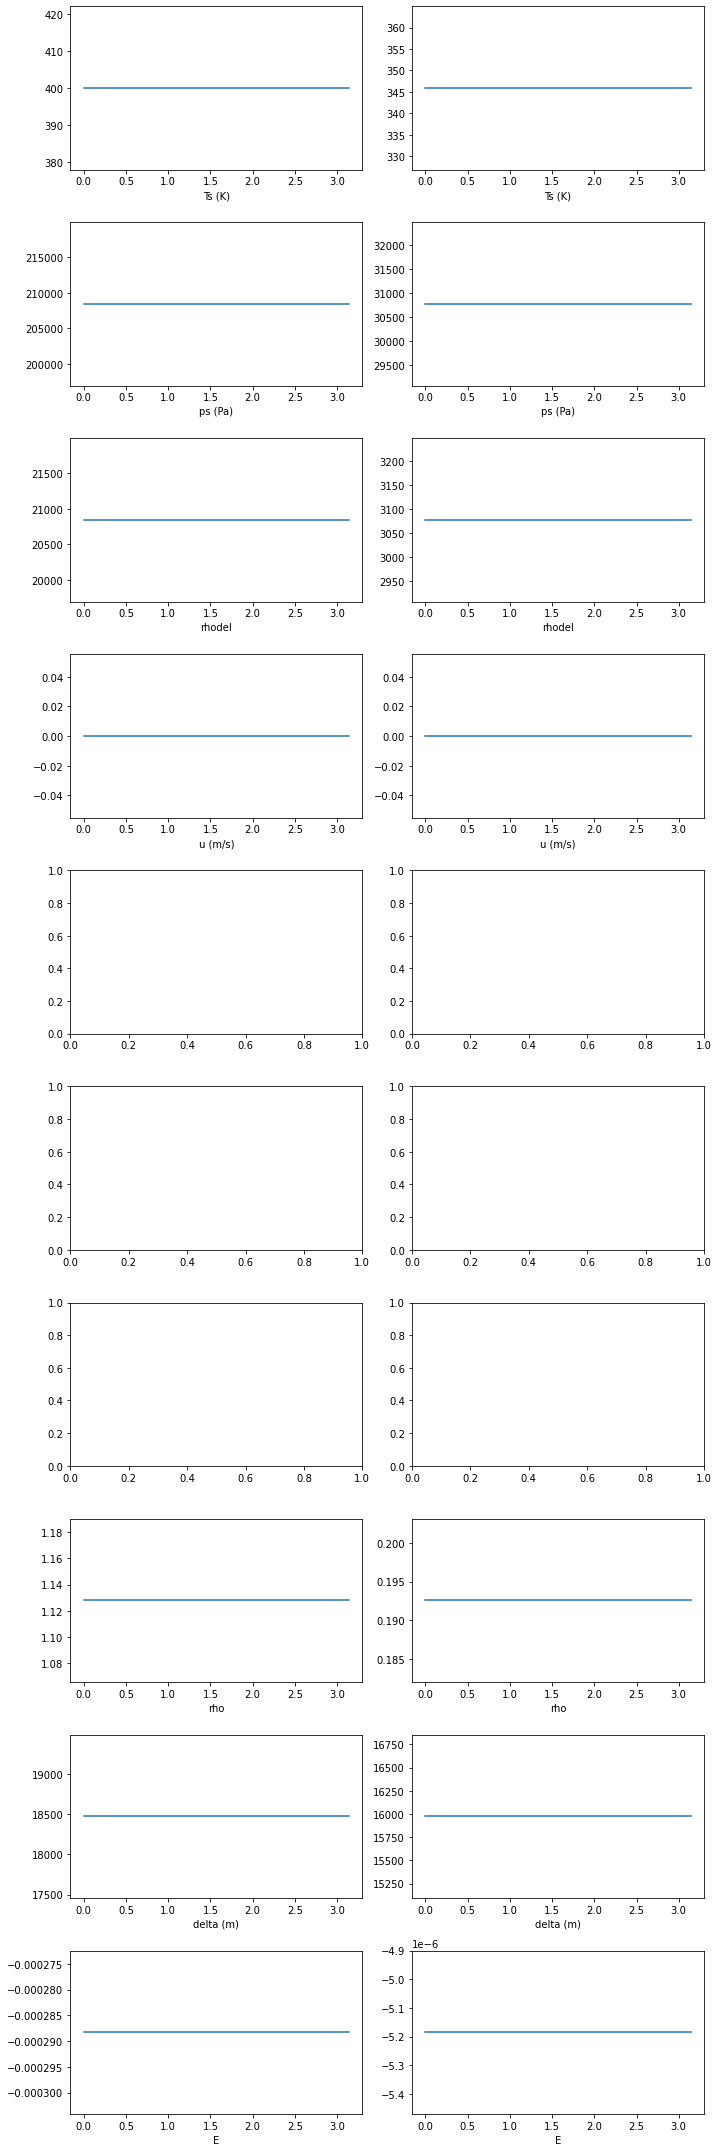

In [172]:
# Plot distribution  
fig, ax = plt.subplots(10,2,figsize=(10,30)) 

# Plot at end of the simulation
ax[0,0].plot(par.x/par.rp,par.Ts[0,:]) 
ax[1,0].plot(par.x/par.rp,par.ps[0,:]) 
ax[2,0].plot(par.x/par.rp,par.rhodel[0,:]) 
ax[3,0].plot(par.x/par.rp,par.u[0,:]) 
# ax[4,0].plot(par.x/par.rp,par.e[0,:]) 
# ax[5,0].plot(par.x/par.rp,par.T[0,:]) 
# ax[6,0].plot(par.x/par.rp,par.p[0,:]) 
ax[7,0].plot(par.x/par.rp,par.rho[0,:]) 
ax[8,0].plot(par.x/par.rp,par.delta[0,:])
ax[9,0].plot(par.x/par.rp,par.E[0,:])

i = -1
ax[0,1].plot(par.x/par.rp,par.Ts[i,:]) 
ax[1,1].plot(par.x/par.rp,par.ps[i,:]) 
ax[2,1].plot(par.x/par.rp,par.rhodel[i,:]) 
ax[3,1].plot(par.x/par.rp,par.u[i,:]) 
# ax[4,1].plot(par.x/par.rp,par.e[i,:]) 
# ax[5,1].plot(par.x/par.rp,par.T[i,:]) 
# ax[6,1].plot(par.x/par.rp,par.p[i,:]) 
ax[7,1].plot(par.x/par.rp,par.rho[i,:]) 
ax[8,1].plot(par.x/par.rp,par.delta[i,:])
ax[9,1].plot(par.x/par.rp,par.E[i,:])

for c in range(0,2):    
    ax[0,c].set_xlabel('Ts (K)')
    ax[1,c].set_xlabel('ps (Pa)')
    ax[2,c].set_xlabel('rhodel')
    ax[3,c].set_xlabel('u (m/s)')
#     ax[4,c].set_xlabel('e')
#     ax[5,c].set_xlabel('T (K)')
#     ax[6,c].set_xlabel('p (Pa)')
    ax[7,c].set_xlabel('rho')
    ax[8,c].set_xlabel('delta (m)')
    ax[9,c].set_xlabel('E')
plt.tight_layout()
plt.show()